# Simulation of BBOB F01

Approach:
- SVM with RBF-Kernel
- 1000 random samples

In [71]:
import sys
import pickle

import numpy as np
from scipy.stats import spearmanr, pearsonr
import pandas as pd
import matplotlib.pyplot as plt
import torch
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.gaussian_process import GaussianProcessRegressor

sys.path.append('..')
from utils.utils import create_problem, plot_collage, test_function
from utils.optimizer import plot_optimization, plot_optimization_paths
from gt_sampling import get_sample

## Create Groundtruth

In [34]:
n_dim = 2
samples = 1000
seed = 42

problem_f01 = create_problem(1, n_dim, seed)

## Sample from Groundtruth

In [35]:
sample_f01 = get_sample(problem_f01, n_samples=samples, n_dim=2, seed=42, method='random')

c:\Users\User\OneDrive\Dokumente\Duales Studium\Theoriephasen\6. Theoriephase\Machine Learning Project (W3WI_DS305.2)\OptimizationTestfunctionGeneration\main\gt_sampling.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_sample = torch.tensor(result[i], dtype=torch.float64).reshape((1, n_dim)).float()


In [36]:
X_input = torch.tensor(sample_f01[0], dtype=torch.float32).clone().detach()
y_input = sample_f01[1].float()  

# input with gradients
X_input_grad1 = torch.tensor(np.concatenate((X_input, sample_f01[2]), axis=1), dtype=torch.float32).clone().detach()

C:\Users\User\AppData\Local\Temp\ipykernel_2228\3495846831.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_input = torch.tensor(sample_f01[0], dtype=torch.float32).clone().detach()


## Train SVM for Simulation

### Classic SVM

In [37]:
svm_p1 = Pipeline([
    ('scaler', StandardScaler()),
    ('model', SVR(kernel='rbf', C=10, gamma=0.6)),
])

In [38]:
svm_p1.fit(X_input, y_input)

Pipeline(steps=[('scaler', StandardScaler()), ('model', SVR(C=10, gamma=0.6))])

Export model:

In [39]:
FOLDER = '../models'
svm1 = pickle.loads(open(f'{FOLDER}/SVM_grad.pkl', 'rb').read())

### SVM with gradients 

In [40]:
svm_grad = Pipeline([
    ('scaler', StandardScaler()),
    ('model', SVR(kernel='rbf', C=10, gamma=0.6)),
])

In [41]:
# train model with gradients
svm_grad.fit(X_input_grad1, y_input)

Pipeline(steps=[('scaler', StandardScaler()), ('model', SVR(C=10, gamma=0.6))])

In [42]:
pickle.dump(svm_grad, open(f'{FOLDER}/SVM-P01-Grads.pkl', 'wb'))

(estimated by nearest neighbor)

In [43]:
# wrap svm and estimate gradients with nearest neighbor
def svm_grad_1nn(X):
    return test_function(X, X_input, X_input_grad1[:, 2:4], svm_grad, method='nearest_neighbor')

(estimated by GPM)

In [44]:
gradient_estimator = MultiOutputRegressor(GaussianProcessRegressor())
gradient_estimator.fit(X_input, X_input_grad1[:, 2:4])

def svm_grad_gpm(X):
    return test_function(X, X_input, X_input_grad1[:, 2:4], svm_grad, method='estimator', gradient_estimator=gradient_estimator)

## Evaluation

### Graphical Evaluation

In [45]:
x1 = x2 = np.linspace(-5.0, 5.0, 100)
X1, X2 = np.meshgrid(x1, x2)

mesh_samples = np.c_[X1.ravel(), X2.ravel()]
mesh_samples_tensor = torch.tensor(mesh_samples, dtype=torch.float32)


In [46]:
mesh_results_svm_p1 = svm_p1.predict(mesh_samples_tensor).reshape(X1.shape)

<Axes: title={'center': 'Ground Truth of BBOB F24 Function'}, xlabel='X', ylabel='Y'>

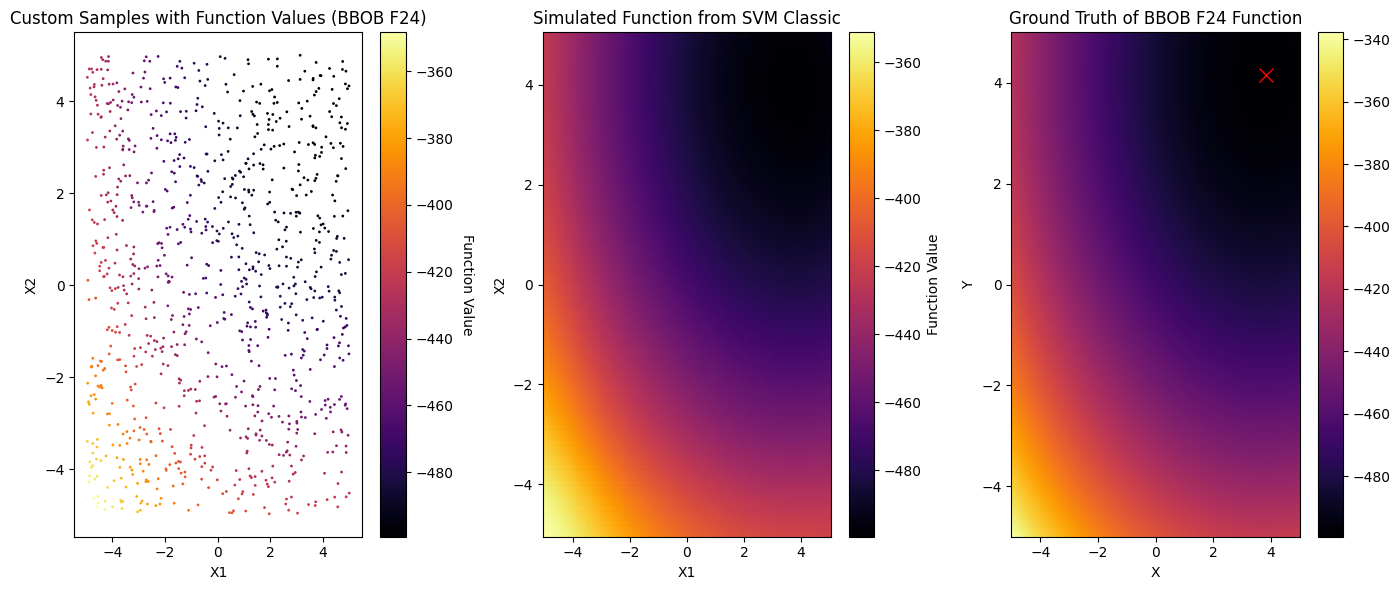

In [47]:
plot_collage(sample_f01[0], sample_f01[1], problem_f01, "BBOB F24", "SVM Classic", X1, X2, mesh_results_svm_p1)

--> on first glance: Classic SVM with RBF-Kernel can simulate the first BBOB function quite well

In [48]:
mesh_results_svm_grad_1nn = svm_grad_1nn(mesh_samples_tensor).reshape(X1.shape)

<Axes: title={'center': 'Ground Truth of BBOB F24 Function'}, xlabel='X', ylabel='Y'>

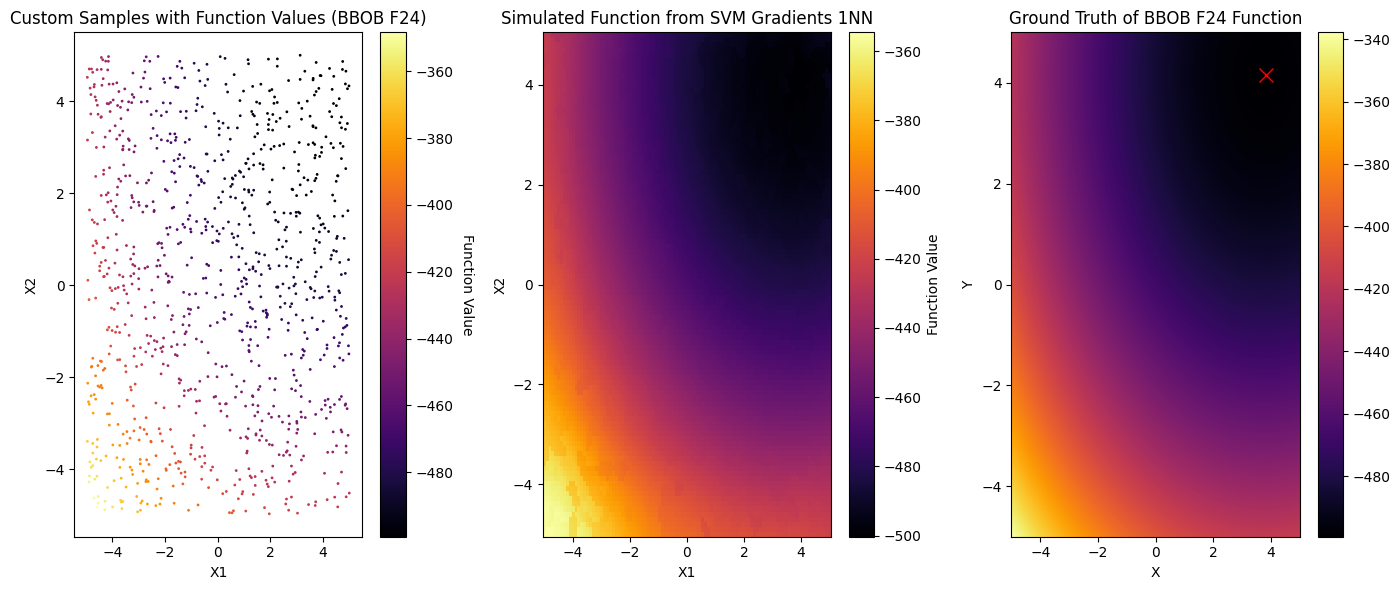

In [49]:
plot_collage(sample_f01[0], sample_f01[1], problem_f01, "BBOB F24", "SVM Gradients 1NN", X1, X2, mesh_results_svm_grad_1nn)

In [50]:
mesh_results_svm_grad_gpm = svm_grad_gpm(mesh_samples_tensor).reshape(X1.shape)

<Axes: title={'center': 'Ground Truth of BBOB F24 Function'}, xlabel='X', ylabel='Y'>

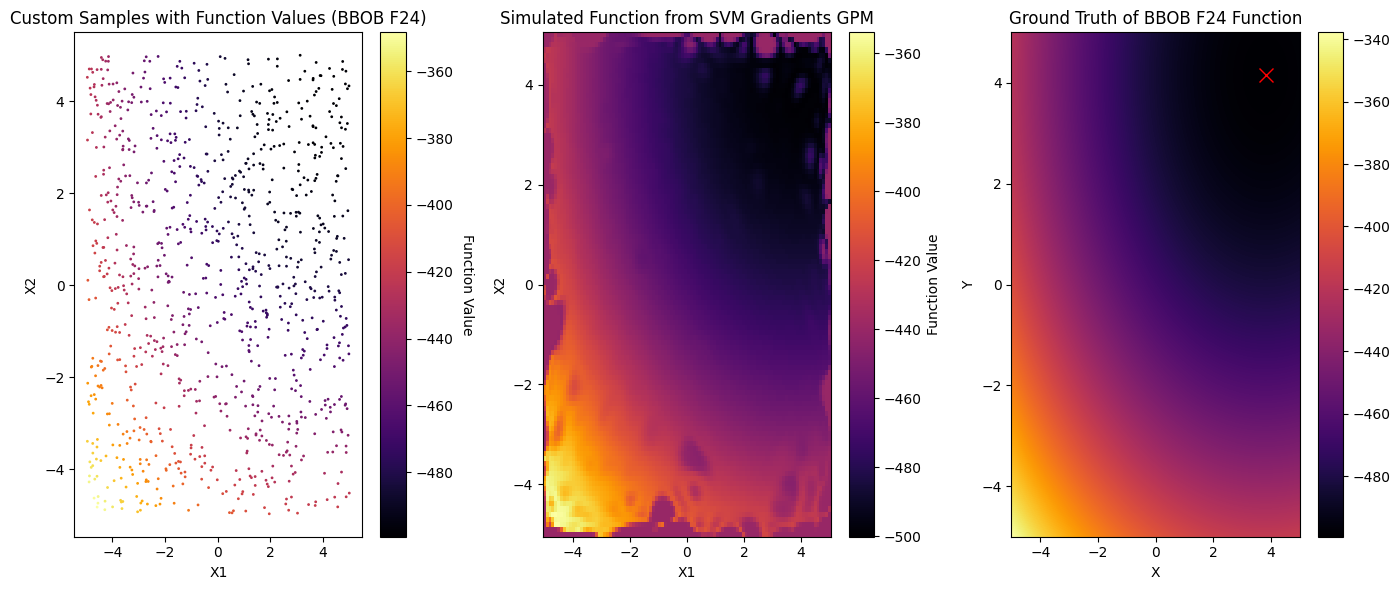

In [51]:
plot_collage(sample_f01[0], sample_f01[1], problem_f01, "BBOB F24", "SVM Gradients GPM", X1, X2, mesh_results_svm_grad_gpm)

### Evaluation with optimizer

In [52]:
svm_classic_f = lambda x: svm_p1.predict(x.reshape(1, -1) if len(x.shape) == 1 else x)
svm_grads_1nn_f = lambda x: svm_grad_1nn(x.reshape(1, -1) if len(x.shape) == 1 else x)
svm_grads_gpm_f= lambda x: svm_grad_gpm(x.reshape(1, -1) if len(x.shape) == 1 else x)

functions = [
               [problem_f01, 'Groundtruth']
             , [svm_classic_f, 'SVM-Classic']
             , [svm_grads_1nn_f, 'SVM-Gradients-1NN']
             , [svm_grads_gpm_f, 'SVM-Gradients-GPM']
]

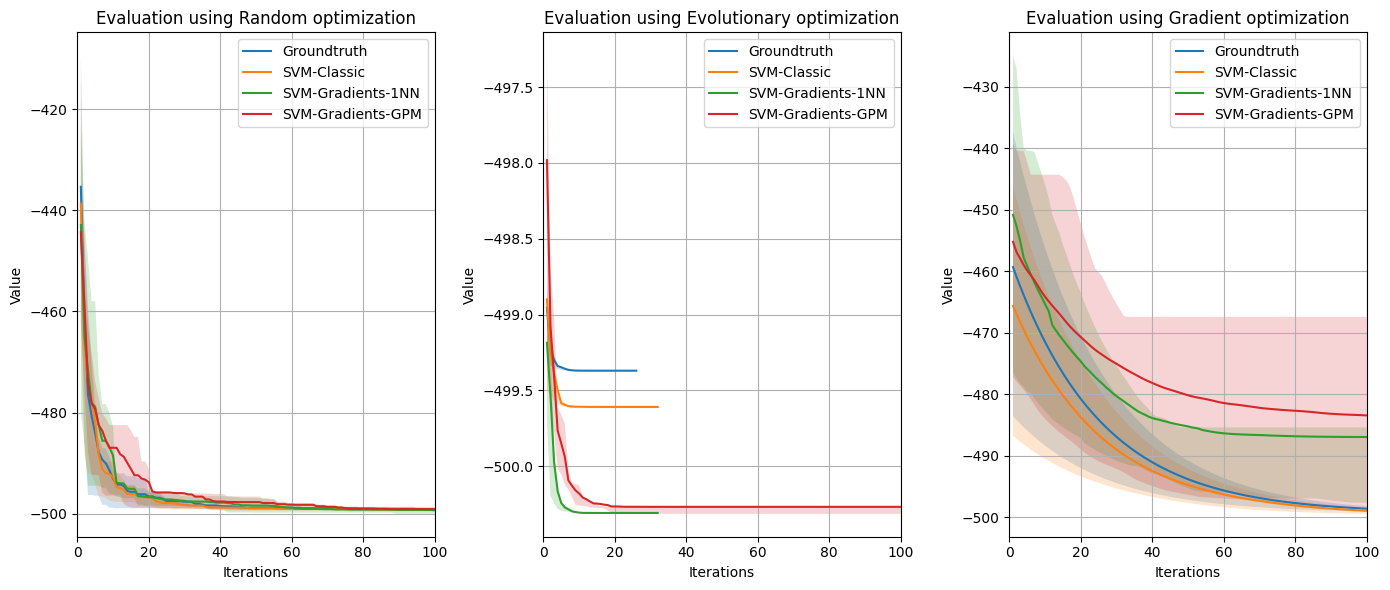

In [53]:
plt.figure(figsize=(14, 6))
ax1 = plt.subplot(1, 3, 1)
plot_optimization(functions, 'Random', n_dim=2, n_times=20, i_evaluations=100)
ax2 = plt.subplot(1, 3, 2)
plot_optimization(functions, 'Evolutionary', n_dim=2, n_times=20, i_evaluations=100)
plt.subplot(1, 3, 3)
plot_optimization(functions, 'Gradient', n_dim=2, n_times=20, i_evaluations=100)
plt.tight_layout()
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_2228\3214168818.py:1: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot_optimization_paths(functions, 'Random', n_dim=2, n_times=20, i_evaluations=100, colors=['tab:blue', 'tab:orange', 'tab:green', 'tab:red']).show()
C:\Users\User\AppData\Local\Temp\ipykernel_2228\3214168818.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot_optimization_paths(functions, 'Evolutionary', n_dim=2, n_times=20, i_evaluations=100, colors=['tab:blue', 'tab:orange', 'tab:green', 'tab:red']).show()
C:\Users\User\AppData\Local\Temp\ipykernel_2228\3214168818.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot_optimization_paths(functions, 'Gradient', n_dim=2, n_times=20, 

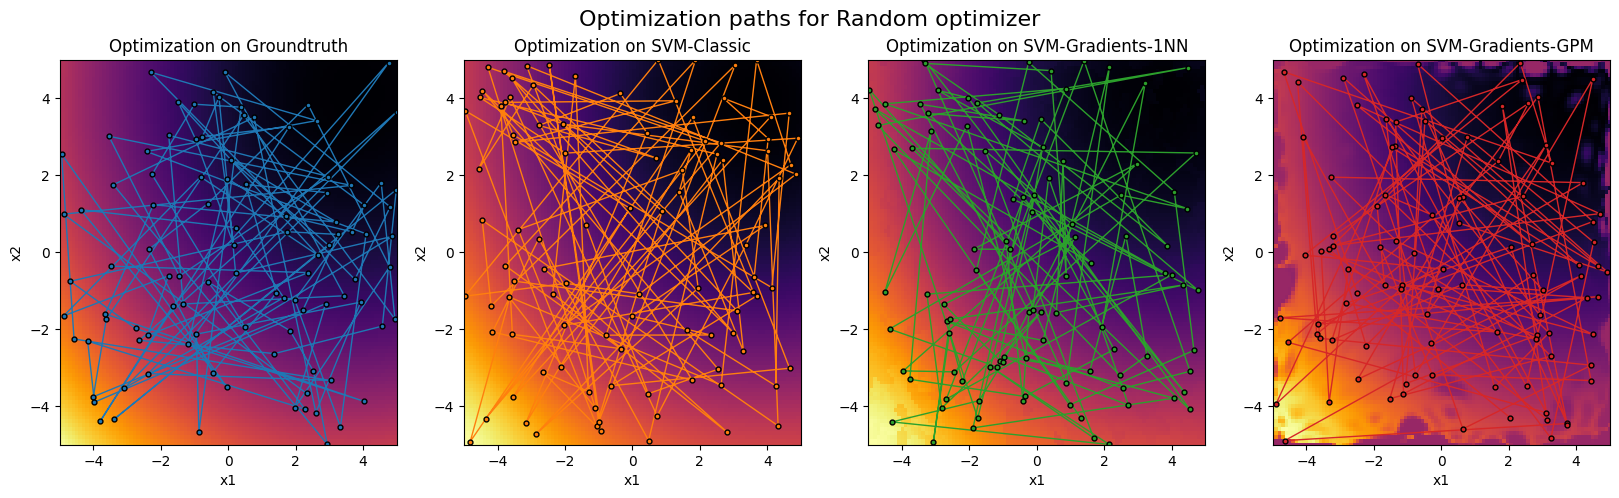

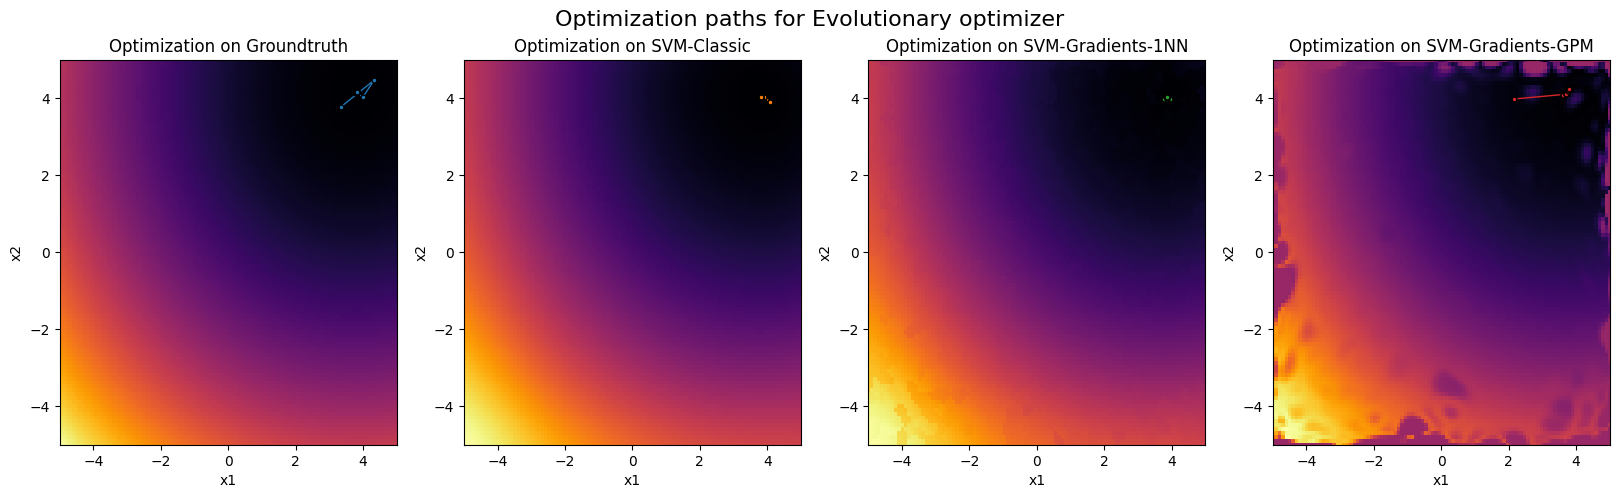

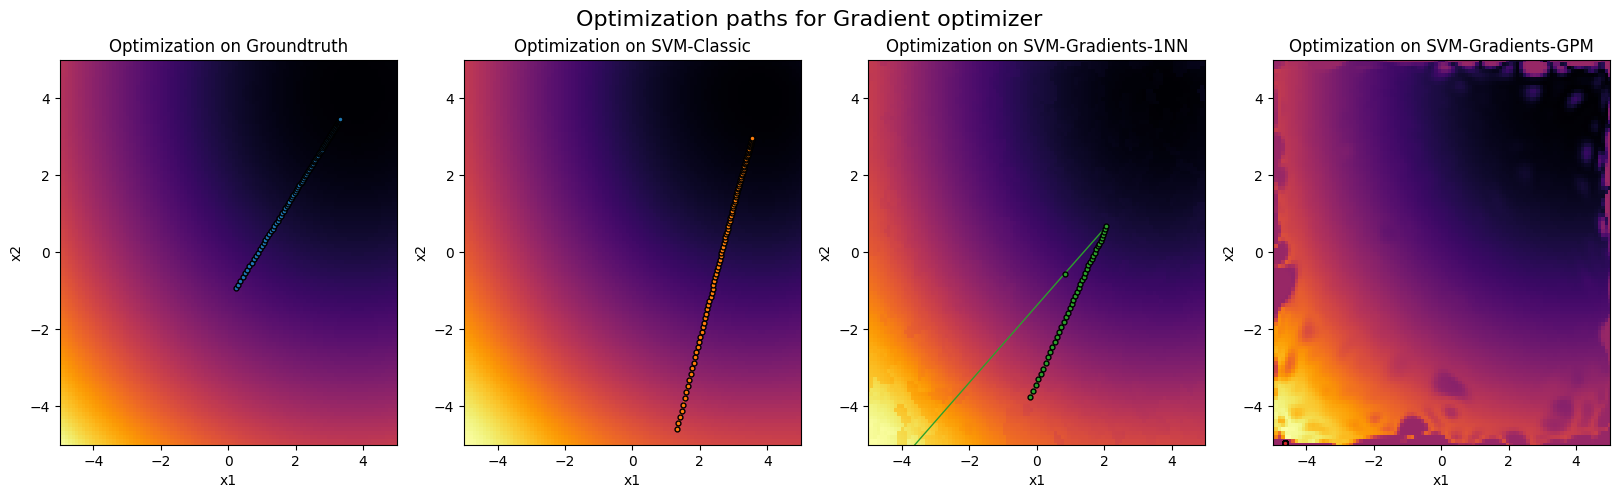

In [54]:
plot_optimization_paths(functions, 'Random', n_dim=2, n_times=20, i_evaluations=100, colors=['tab:blue', 'tab:orange', 'tab:green', 'tab:red']).show()
plot_optimization_paths(functions, 'Evolutionary', n_dim=2, n_times=20, i_evaluations=100, colors=['tab:blue', 'tab:orange', 'tab:green', 'tab:red']).show()
plot_optimization_paths(functions, 'Gradient', n_dim=2, n_times=20, i_evaluations=100, colors=['tab:blue', 'tab:orange', 'tab:green', 'tab:red']).show()

In [55]:
# TODO: correct path for evolutionary optimization
# TODO: mark the found (and for groudtruth actual) minimum

### Evaluation with metrics

#### Spearman Correlation

In [79]:
n_samples = 100
n_resampling = 10
df_corr_rho = pd.DataFrame(columns=[function[1] for function in functions])
df_corr_r = pd.DataFrame(columns=[function[1] for function in functions])

for i in range(n_resampling):
    X_test, y_test, _, _ = get_sample(problem_f01, n_samples=n_samples, n_dim=2, seed=i, method='random')
    row_r = []
    row_rho = []
    for function in functions:
        row_r.append(pearsonr(y_test, function[0](X_test))[0])
        row_rho.append(spearmanr(y_test, function[0](X_test))[0])
    df_corr_rho.loc[len(df_corr_rho)] = row_rho
    df_corr_r.loc[len(df_corr_r)] = row_r

c:\Users\User\OneDrive\Dokumente\Duales Studium\Theoriephasen\6. Theoriephase\Machine Learning Project (W3WI_DS305.2)\OptimizationTestfunctionGeneration\main\gt_sampling.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_sample = torch.tensor(result[i], dtype=torch.float64).reshape((1, n_dim)).float()
c:\Users\User\OneDrive\Dokumente\Duales Studium\Theoriephasen\6. Theoriephase\Machine Learning Project (W3WI_DS305.2)\OptimizationTestfunctionGeneration\main\gt_sampling.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_sample = torch.tensor(result[i], dtype=torch.float64).reshape((1, n_dim)).float()
c:\Users\User\OneDrive\Dokumente\Duales Studium\Theoriephasen\6. Theorie

,Groundtruth,SVM-Classic,SVM-Gradients-1NN,SVM-Gradients-GPM
0,1.0,0.999892,0.999688,0.982370
1,1.0,0.999880,0.999280,0.963756
2,1.0,0.999844,0.999748,0.949787
3,1.0,0.999856,0.999748,0.954287
4,1.0,0.999736,0.999616,0.925217
5,1.0,0.999820,0.999616,0.929541
6,1.0,0.999856,0.999616,0.969769
7,1.0,0.999784,0.999568,0.967684
8,1.0,0.999844,0.999160,0.976523
9,1.0,0.999868,0.999424,0.993147


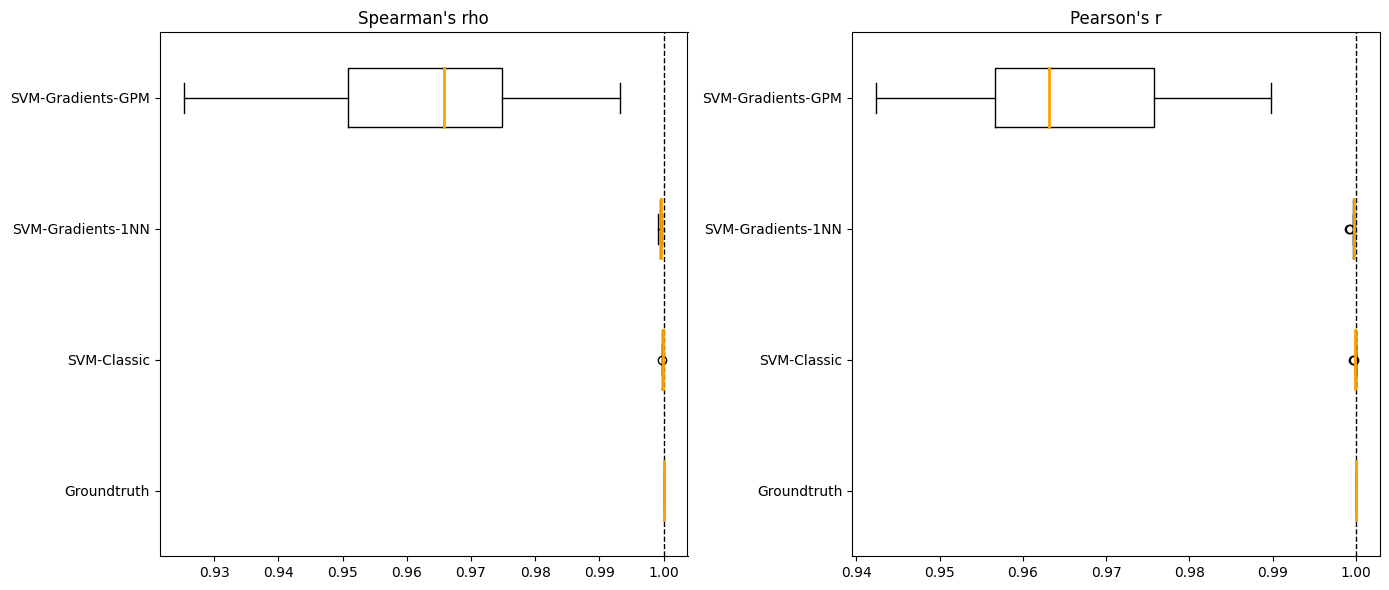

In [116]:
# boxplot of correlation coefficients
plt.figure(figsize=(14, 6))
plt.subplot(121)
plt.title("Spearman's rho")
df_corr_rho.boxplot(grid=False, vert=False, medianprops={'color': 'orange', 'linewidth': 2}, whiskerprops={'color': 'black', 'linewidth': 1}, capprops={'color': 'black', 'linewidth': 1}, flierprops={'color': 'black', 'linewidth': 1}, boxprops={'color': 'black', 'linewidth': 1})
plt.vlines(x=1, ymin=0.5, ymax=len(df_corr_rho.columns)+0.5, color='black', linestyles='dashed', linewidth=1)
plt.subplot(122)
plt.title("Pearson's r")
df_corr_r.boxplot(grid=False, vert=False, medianprops={'color': 'orange', 'linewidth': 2}, whiskerprops={'color': 'black', 'linewidth': 1}, capprops={'color': 'black', 'linewidth': 1}, flierprops={'color': 'black', 'linewidth': 1}, boxprops={'color': 'black', 'linewidth': 1})
plt.vlines(x=1, ymin=0.5, ymax=len(df_corr_rho.columns)+0.5, color='black', linestyles='dashed', linewidth=1)
plt.tight_layout()
plt.show()

In [76]:
df_corr = pd.DataFrame(columns=['Model', 'Spearman', 'Pearson'])

df_corr.loc[len(df_corr)] = ['Groundtruth', spearmanr(y_test, problem_f01(X_test))[0], pearsonr(y_test, problem_f01(X_test))[0]]
df_corr.loc[len(df_corr)] = ['SVM-Classic', spearmanr(y_test, svm_p1.predict(X_test))[0], pearsonr(y_test, svm_p1.predict(X_test))[0]]
df_corr.loc[len(df_corr)] = ['SVM-Gradients-1NN', spearmanr(y_test, svm_grad_1nn(X_test))[0], pearsonr(y_test, svm_grad_1nn(X_test))[0]]
df_corr.loc[len(df_corr)] = ['SVM-Gradients-GPM', spearmanr(y_test, svm_grad_gpm(X_test))[0], pearsonr(y_test, svm_grad_gpm(X_test))[0]]
df_corr

,Model,Spearman,Pearson
0,Groundtruth,1.000000,1.000000
1,SVM-Classic,0.999971,0.999878
2,SVM-Gradients-1NN,0.999822,0.999609
3,SVM-Gradients-GPM,0.972899,0.968279
